<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preliminary-data-analysis" data-toc-modified-id="Preliminary-data-analysis-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preliminary data analysis</a></span><ul class="toc-item"><li><span><a href="#Loading-data" data-toc-modified-id="Loading-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Loading data</a></span></li><li><span><a href="#Dataset-overview" data-toc-modified-id="Dataset-overview-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Dataset overview</a></span></li><li><span><a href="#Resampling" data-toc-modified-id="Resampling-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Resampling</a></span></li></ul></li><li><span><a href="#Time-Series-Analysis" data-toc-modified-id="Time-Series-Analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Time Series Analysis</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Training</a></span><ul class="toc-item"><li><span><a href="#Feature-Generation" data-toc-modified-id="Feature-Generation-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Feature Generation</a></span></li><li><span><a href="#Search-for-optimal-set-of-input-features" data-toc-modified-id="Search-for-optimal-set-of-input-features-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Search for optimal set of input features</a></span></li><li><span><a href="#Feature-Selection" data-toc-modified-id="Feature-Selection-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Feature Selection</a></span></li><li><span><a href="#Genarating-Training-and-Test-Datasets" data-toc-modified-id="Genarating-Training-and-Test-Datasets-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Genarating Training and Test Datasets</a></span></li><li><span><a href="#Training-on-three-different-models" data-toc-modified-id="Training-on-three-different-models-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Training on three different models</a></span></li><li><span><a href="#Best-model-selection" data-toc-modified-id="Best-model-selection-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Best model selection</a></span></li></ul></li><li><span><a href="#Testing" data-toc-modified-id="Testing-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Testing</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></div>

#  Taxi Order Forecasting

A taxicab company has collected historical data on taxi orders at airports. To attract more drivers during peak demand periods, it is necessary to forecast the number of taxi orders for the next hour. 

**Objective:** Train a machine learning model that accurately predicts the required number of taxis for the next hour.

To do:

1. Load the data and resample it on an hourly basis.
2. Analyze the data.
3. Train various models with different hyperparameters. Create a test set comprising 10% of the original data.
4. Evaluate the model on the test set.

The data are stored in the file taxi.csv, and the number of orders is in the column num_orders.

Importing necessary libraries and functions.

In [1]:
import os
import pandas as pd   
import numpy as np
from scipy import stats as st
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.model_selection import train_test_split

import lightgbm
from lightgbm import LGBMRegressor 

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (OrdinalEncoder,
                                   StandardScaler,
                                   MinMaxScaler)
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import TimeSeriesSplit

from sklearn.impute import SimpleImputer

import phik

from helper_functions import (importseries
                             ,split2train_test4tseries
                             ,make_features)
plt.rcParams.update({'font.size': 14})

## Preliminary data analysis

### Loading data

We will convert the datetime column from the object type to the datetime type, set the index to the datetime column, and check the index for monotonicity. 

In [2]:
filedirs = ['../datasets/']

    
fname = 'taxi.csv'

taxi = importseries(filedirs,fname)
taxi.sort_index(inplace=True)
print(taxi.index.is_monotonic)

File taxi.csv is loaded from ../datasets/
True


Next, we'll display the changes and take a look at the first five rows for a preliminary data preview.

### Dataset overview

In [3]:
taxi.info()
display(taxi.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
display(taxi.describe().T)

,count,mean,std,min,25%,50%,75%,max
num_orders,26496.0,14.070463,9.21133,0.0,8.0,13.0,19.0,119.0


Number of rows: 26,496.

Average number of orders: 9.2.

Maximum number of orders: 119.

### Resampling

We'll resample the data by one hour and calculate the average number of orders per hour, as well as the total number of orders during each hour.

In [5]:
taxi_rsmpld = taxi.resample('1H').sum()

## Time Series Analysis

In [6]:
xlabel = 'Date'
ylabel = 'Number of orders'

Let's visualize the time series.

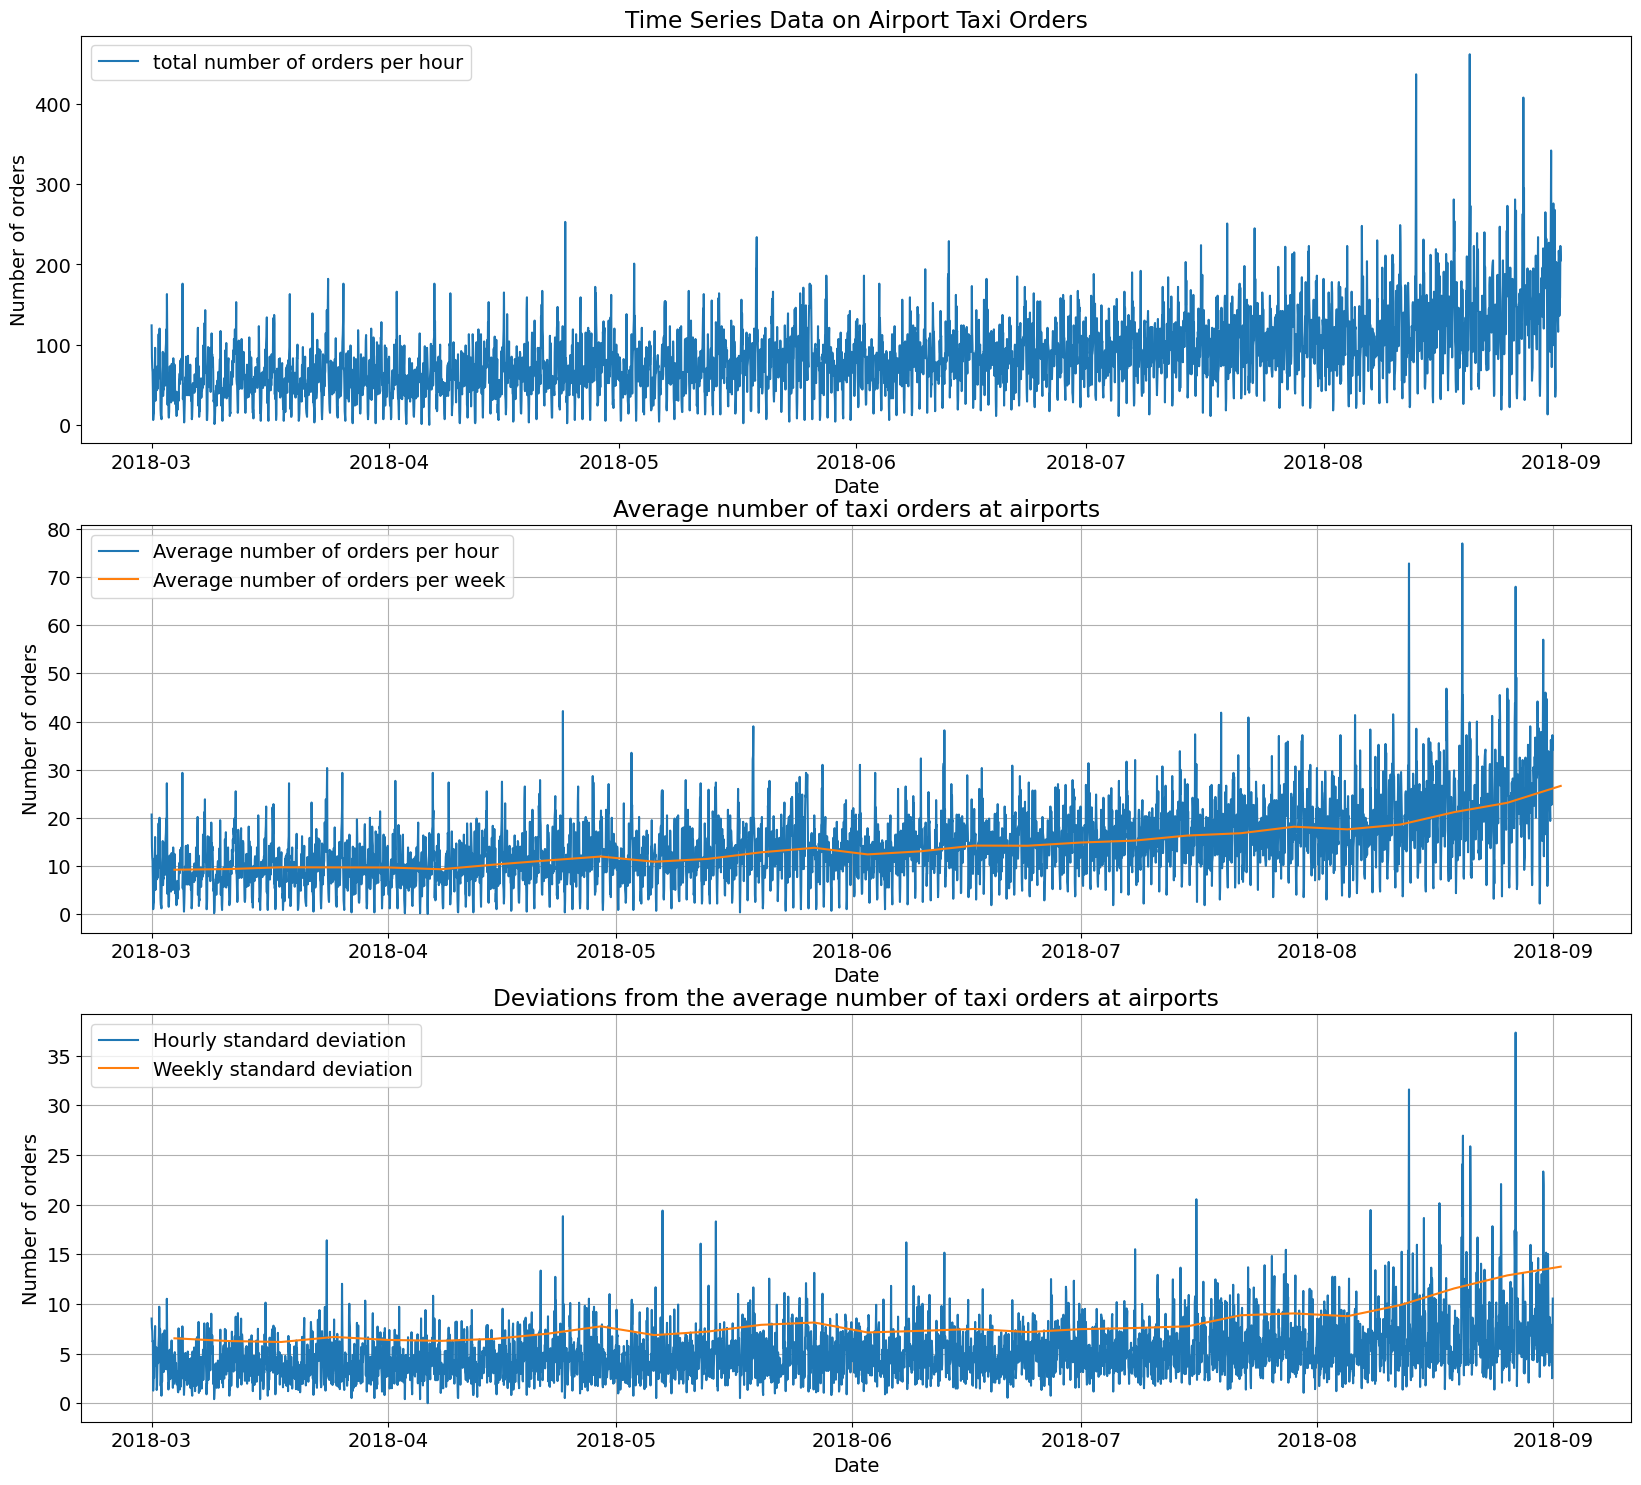

In [7]:
fig, ax = plt.subplots(3,1,figsize=(20,18))

sns.lineplot(data=taxi_rsmpld,x=taxi_rsmpld.index,y='num_orders',
             ax=ax[0]
             ,label='total number of orders per hour')

ax[0].set_title('Time Series Data on Airport Taxi Orders')

d = taxi.resample('1H').mean()
sns.lineplot(data=d,
                x=d.index,
                y='num_orders',
                ax=ax[1],
                label='Average number of orders per hour'
                )
d = taxi.resample('1W').mean()
sns.lineplot(data=d,
                x=d.index,
                y='num_orders',
                ax=ax[1],
                label='Average number of orders per week'
                )
ax[1].set_title('Average number of taxi orders at airports')
ax[1].grid()

d = taxi.resample('1H').std()
sns.lineplot(data=d,
                x=d.index,
                y='num_orders',
                ax=ax[2],
                label='Hourly standard deviation'
                )

d = taxi.resample('1W').std()
sns.lineplot(data=d,
                x=d.index,
                y='num_orders',
                ax=ax[2],
                label='Weekly standard deviation'
                )

ax[2].set_title('Deviations from the average number of taxi orders at airports')
ax[2].grid()
for i in range(3):
    ax[i].set_xlabel(xlabel)
    ax[i].set_ylabel(ylabel)


plt.show()

We observe that the time series of airport taxi orders is a non-stationary process: both the mean and standard deviation increase from March to September. To examine this in more detail, we will decompose the time series into its components.

Next, we will apply the Dickey-Fuller test with significance levels of $\alpha = 0.01$ and $0.05$, and compare the results with the p-value.

Hypotheses:

$H_0$: The series is non-stationary,

$H_a$: The alternative hypothesis – the series is stationary.

If the p-value is greater than alpha, we fail to reject the null hypothesis, meaning the series is non-stationary. Otherwise, the series is considered stationary.

In [8]:
def test_hypoth(pvalue,alpha):
    if pvalue>alpha:
        return 'reject H0'
    else:
        return 'accept Ha'
        

df_res = pd.DataFrame(columns=['Interval','p-value','alpha=0.01','alpha=0.05'])

thres = 0.05
pvalues = []
ws = ['1H'\
     ,'2H'\
     ,'6H','1D','1M'
          ]
for w  in ws:
    pvalues.append(adfuller(taxi.resample(w).sum())[1])
    
df_res['Interval'] = ws
df_res['p-value'] = pvalues
df_res['alpha=0.01'] = df_res['p-value'].apply(test_hypoth, args=(0.01,))
df_res['alpha=0.05'] = df_res['p-value'].apply(test_hypoth, args=(0.05,))
display(df_res)

,Interval,p-value,alpha=0.01,alpha=0.05
0,1H,0.028940,reject H0,accept Ha
1,2H,0.943563,reject H0,reject H0
2,6H,0.998494,reject H0,reject H0
3,1D,1.000000,reject H0,reject H0
4,1M,0.998457,reject H0,reject H0


At different sampling intervals, the Dickey-Fuller test with a significance level of 0.01 indicates that we cannot reject the non-stationarity of the series. With a significance level of 0.05, and for closely related intervals of 1 hour and 2 hours, the results are conflicting, but there is agreement over other time periods. We conclude that our series is non-stationary.

In [9]:
decomposed = seasonal_decompose(taxi_rsmpld) 

Let’s plot the three components: trend, seasonality, and residuals.

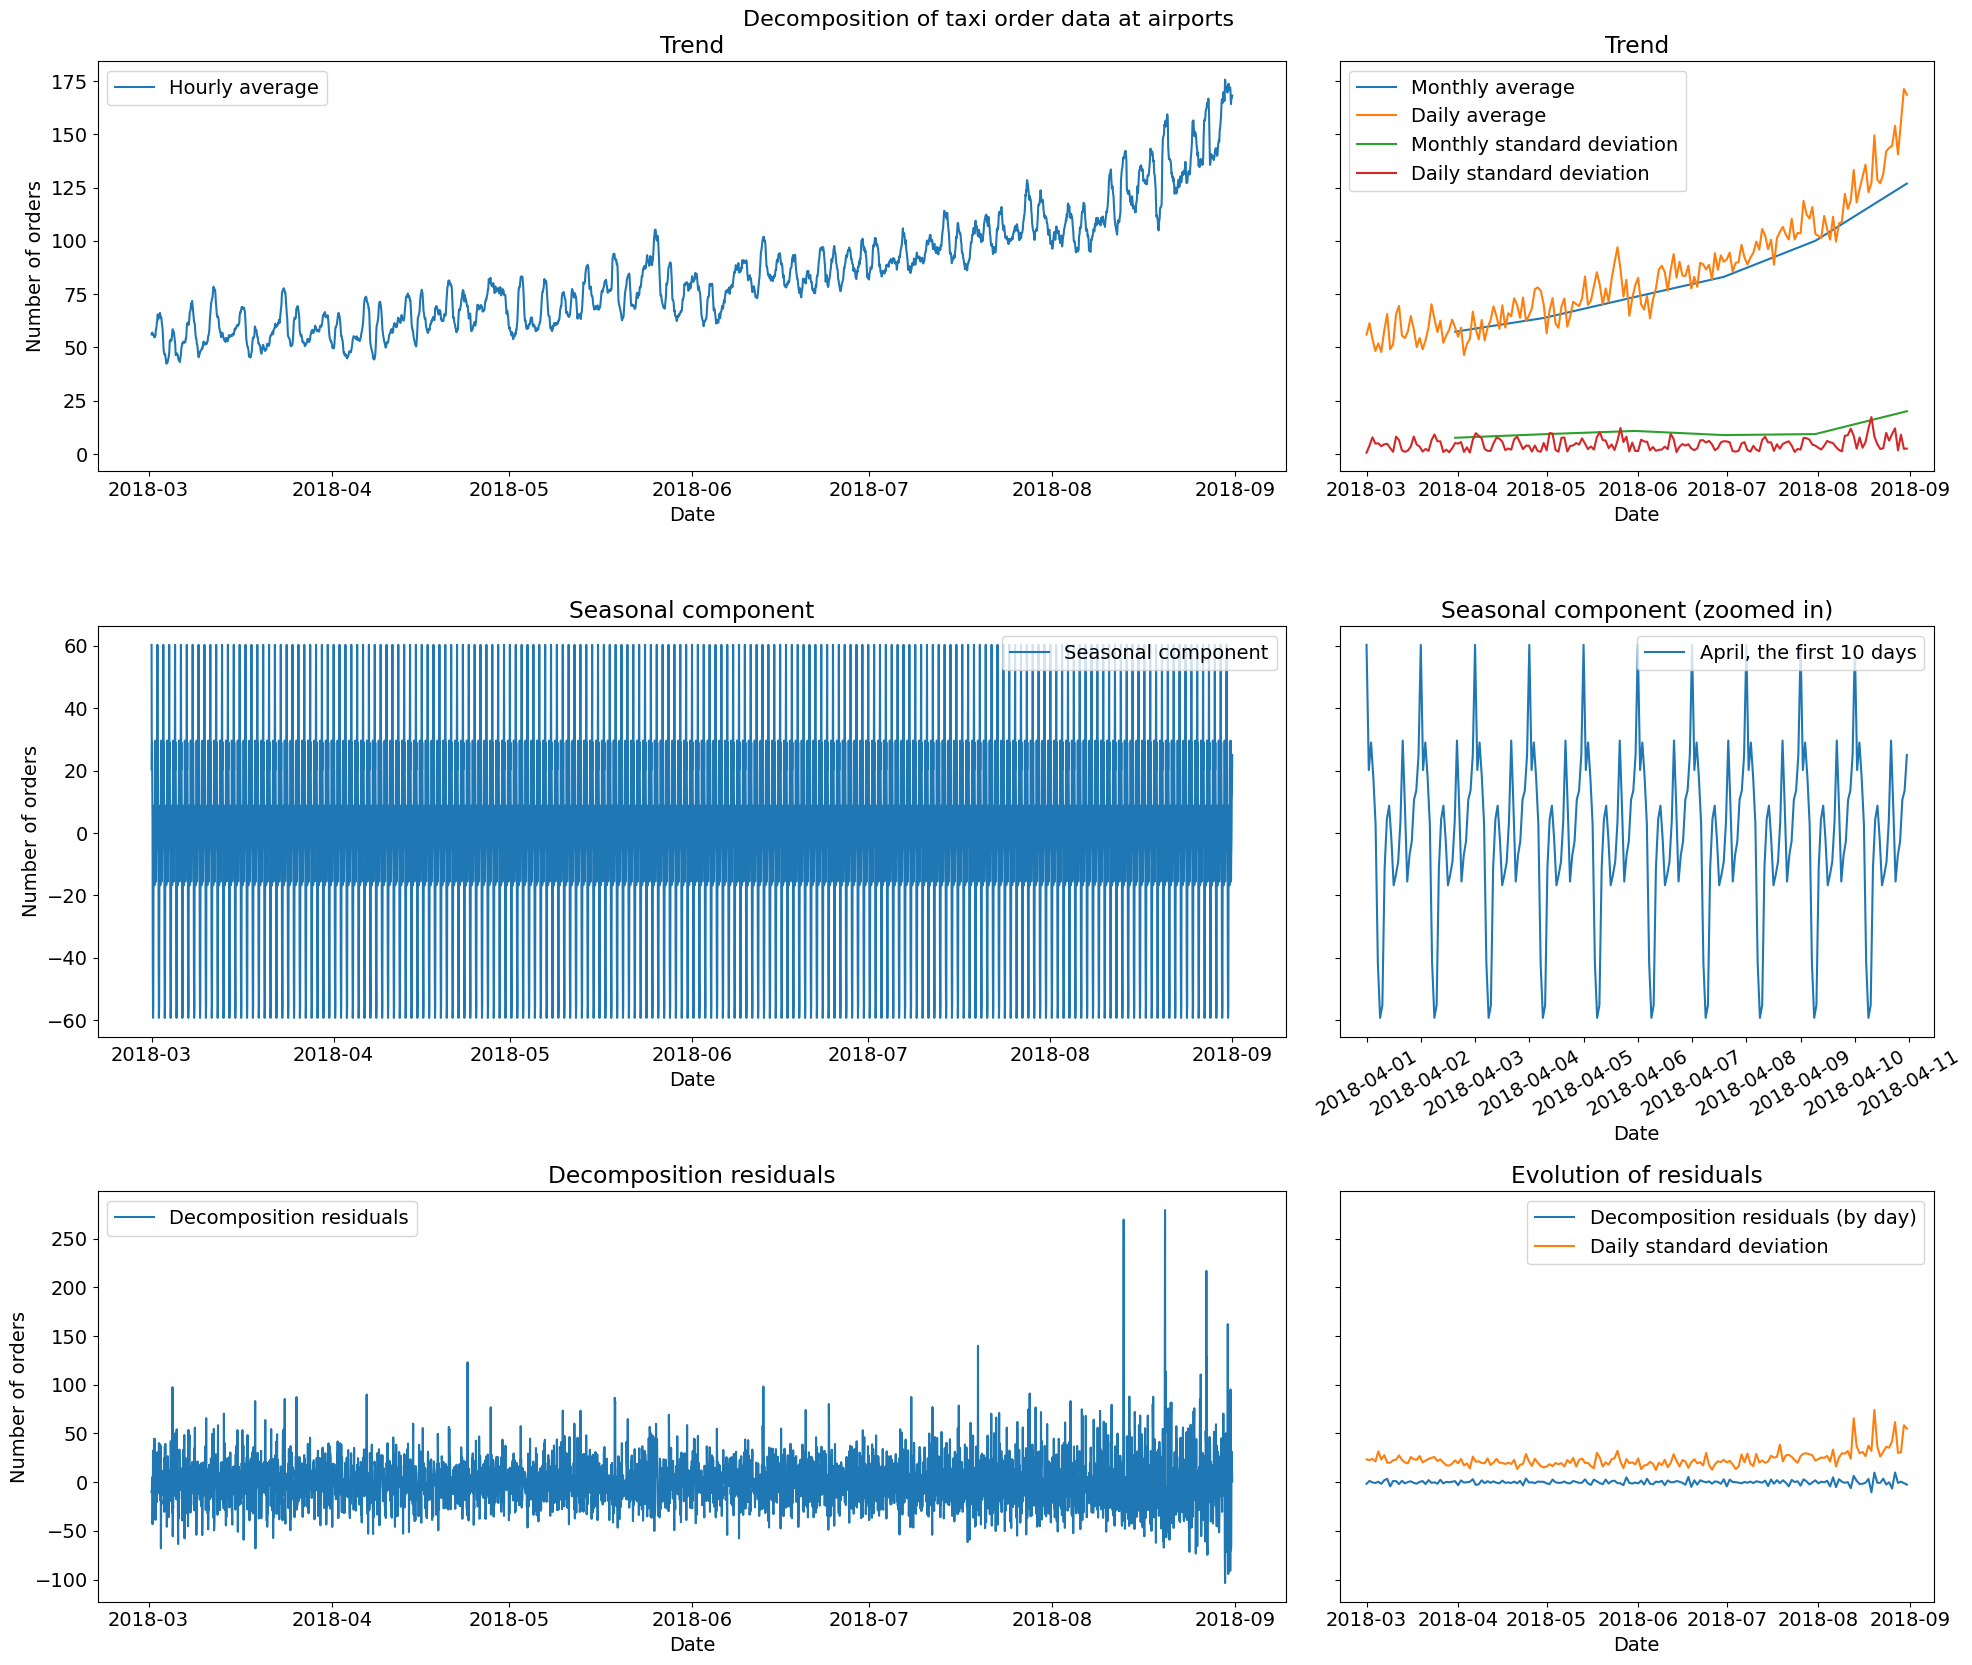

In [10]:
fig, ax = plt.subplots(3,2,figsize=(20,17)

                      ,sharey='row'
                      ,gridspec_kw={'width_ratios': [2,1]})
plt.subplots_adjust(hspace = 0.3)

sns.lineplot(data=decomposed.trend,
                ax=ax[0,0],
                label='Hourly average'
                )

ax[0,0].set_title('Trend')
sns.lineplot(data=decomposed.trend.resample('1M').mean(),
                ax=ax[0,1],
                label='Monthly average'
                )
sns.lineplot(data=decomposed.trend.resample('1D').mean(),
                ax=ax[0,1],
                label='Daily average'
                )
sns.lineplot(data=decomposed.trend.resample('1M').std(),
                ax=ax[0,1],
                label='Monthly standard deviation'
                )
sns.lineplot(data=decomposed.trend.resample('1D').std(),
                ax=ax[0,1],
                label='Daily standard deviation'
                )
ax[0,1].set_title('Trend')

sns.lineplot(data=decomposed.seasonal,
                ax=ax[1,0],
                label='Seasonal component'
                )
ax[1,0].set_title('Seasonal component')

sns.lineplot(data=decomposed.seasonal['2018-04-01':'2018-04-10'],
                ax=ax[1,1],
                label='April, the first 10 days'
                )
ax[1,1].tick_params(axis='x',rotation=30)

ax[1,1].set_title('Seasonal component (zoomed in)')

sns.lineplot(data=decomposed.resid,
                ax=ax[2,0],
                label='Decomposition residuals'
                )
ax[2,0].set_title('Decomposition residuals')

sns.lineplot(data=decomposed.resid.resample('1D').mean(),
                ax=ax[2,1],
                label='Decomposition residuals (by day)'
                )
sns.lineplot(data=decomposed.resid.resample('1D').std(),
                ax=ax[2,1],
                label='Daily standard deviation'
                )
ax[2,1].set_title('Evolution of residuals')

for i in range(3):
    ax[i,0].set_xlabel(xlabel)
    ax[i,1].set_xlabel(xlabel)
    ax[i,0].set_ylabel(ylabel)

plt.suptitle('Decomposition of taxi order data at airports',fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

* We observe that the trend is characterized by an increasing mean and oscillating deviation, with a slight rise as we get closer to the Fall. 


* The seasonal component can be classified as a stationary stochastic process. 


* If we exclude the period closer to September, the noise represented by the decomposition residuals can be roughly approximated by a normal distribution.

From the plot of the seasonal component above, we can see that the pattern in the total number of orders repeats daily. Since these are airport taxis, the number of taxis is directly related to the flight schedule, such as arrivals, departures, and their combinations, as well as overlapping periods.

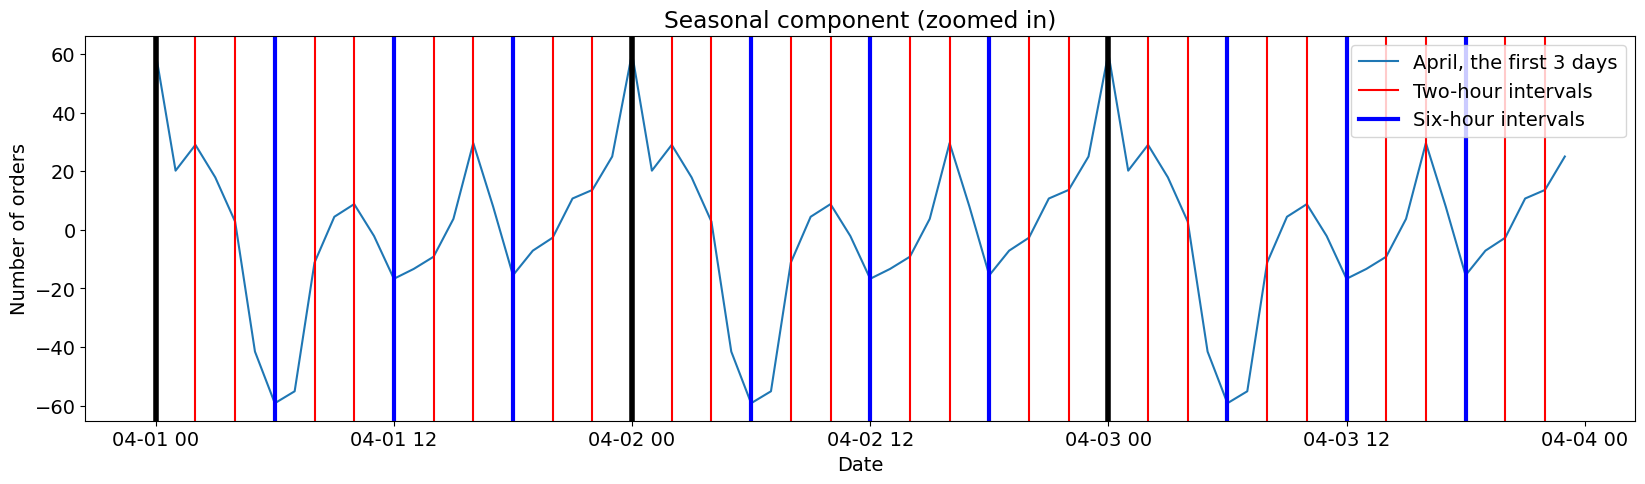

In [11]:
fig, ax = plt.subplots(1,1,figsize=(20,5))

sns.lineplot(data=decomposed.seasonal['2018-04-01':'2018-04-03'],
                ax=ax,
                label='April, the first 3 days'
                )

nh = 4
dh = int(24/nh) 
label2='Two-hour intervals'

for day in ['2018-04-01','2018-04-02','2018-04-03']:
    ax.axvline(pd.to_datetime(day),color='k',lw=4)
    for i in range(1,12):
        ax.axvline(pd.to_datetime(day)+ pd.Timedelta(hours=i*2)
               ,color='r',label=label2)
        label2=''
    for h in range(1,nh):
        if h==1 and day=='2018-04-01':
            label6='Six-hour intervals'
        else:
            label6=''
        ax.axvline(pd.to_datetime(day)+ pd.Timedelta(hours=h*dh)
                   ,color='b'
                  ,label=label6,lw=3)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
plt.legend()
plt.title('Seasonal component (zoomed in)')
plt.show()

We observe that the same pattern repeats daily: the peak number of orders occurs at midnight. Declines or increases mainly happen over two-hour intervals. A drop starts from midnight until 6 AM, followed by a rise in orders until 10 AM, which then decreases until noon. From noon, there is a rise until 4 PM, then a decline until 6 PM, and finally, an increase in orders until midnight.

## Training

### Feature Generation

The year is fixed, so we won't consider this feature.

### Search for optimal set of input features

We'll experiment with different combinations of lag and moving window sizes, keeping in mind that typical time scales could be hours, days, etc. Using linear regression, we'll aim to find such parameters for feature generation that minimize the difference in RMSE between the training and test datasets, and we'll rank them by the test set RMSE.

In [12]:
lags = [2\
        ,3,4,5,6,7,8,9
       ]
rolling_mean_sizes = [7\
                      ,12,14,21,24,28,30
                     ]

lags = np.arange(1,10,1)
rolling_mean_sizes = np.arange(5,32,1)

res = pd.DataFrame()

model = LinearRegression() 

i = 0
for lag in lags:
    for rolling_mean_size in rolling_mean_sizes:
        
        data_tmp = make_features(taxi_rsmpld, lag, rolling_mean_size)

        data_tmp = data_tmp.dropna()

        train, test = train_test_split(data_tmp, shuffle=False, test_size=0.1)
        
        cvs = cross_validate(model, train.drop('num_orders',axis=1),train['num_orders']
                        ,cv=TimeSeriesSplit()
                        ,scoring='neg_root_mean_squared_error')
        
        res.loc[i,'lag'] = lag
        res.loc[i,'size'] = rolling_mean_size
        res.loc[i,'<RMSE_valid>'] = -cvs['test_score'].mean()

        i+=1

display(res.sort_values(by='<RMSE_valid>').head(10))

,lag,size,<RMSE_valid>
236,9.0,25.0,31.496730
237,9.0,26.0,31.571267
235,9.0,24.0,31.586104
101,4.0,25.0,31.605550
74,3.0,25.0,31.646517
102,4.0,26.0,31.651417
155,6.0,25.0,31.663275
238,9.0,27.0,31.673277
100,4.0,24.0,31.686772
75,3.0,26.0,31.687577


The parameters found for generating input features are a lag of up to 9 hours and a moving window of 25 hours. Now, we'll generate the features from the original time series.

In [13]:
max_lag = 9
rolling_mean_size = 25

data = make_features(taxi_rsmpld, max_lag, rolling_mean_size)

data.dropna(inplace=True)

Everything is ready for training after removing rows with missing values.

### Feature Selection

List of numerical input features:

In [14]:
num_columns = data.drop('num_orders',axis=1).columns.to_list()
print(num_columns)

['day', 'dayofweek', 'hours', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'rolling_mean']


We'll use a correlation matrix to identify features correlating with the target.

In [15]:
cor_matr = data.sample(frac=1.0).phik_matrix(
           interval_cols=num_columns)

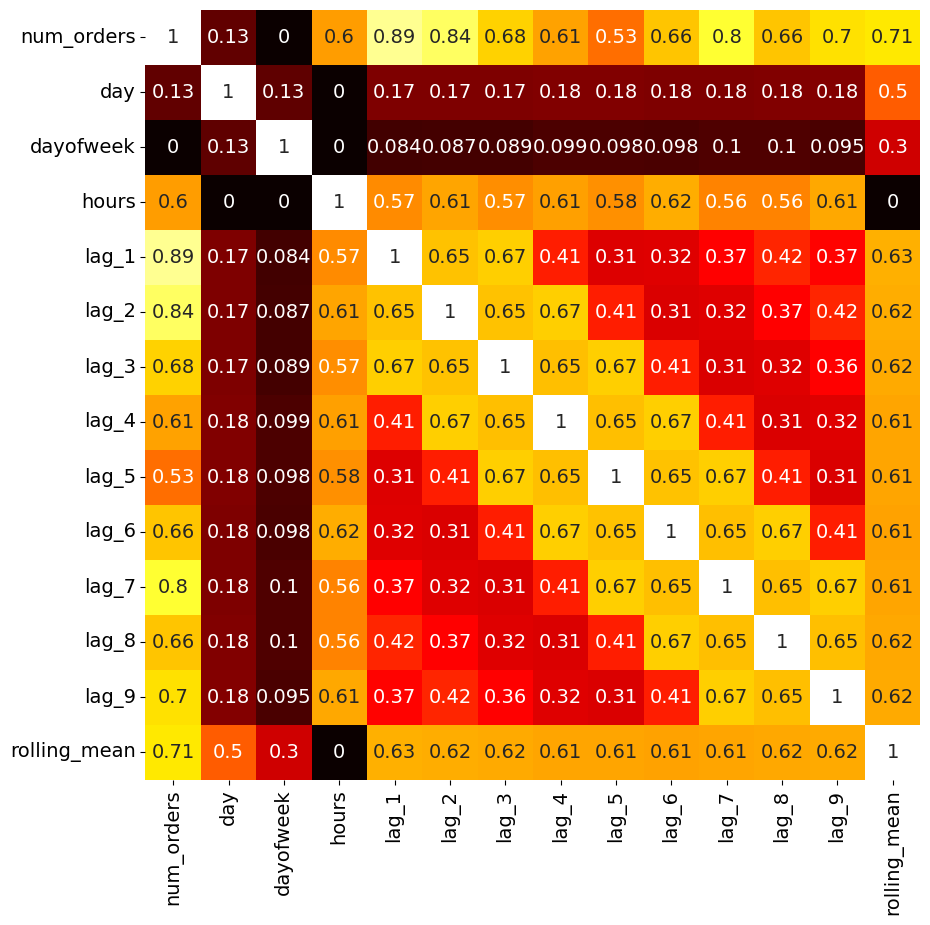

In [16]:
fig, ax = plt.subplots(1, 1,figsize=(10,10))
sns.heatmap(cor_matr, annot=True,ax=ax, cmap="hot",cbar=False)
plt.show()

We observe that the number of orders does not correlate with the day of the week, and there is no multicollinearity. There is a strong correlation between the number of orders and lag features (lag_1, lag_2, lag_7, lag_9) as well as the rolling mean. A moderate correlation is observed with hours, lag_3, lag_4, lag_5, lag_6, and lag_8. There is almost no correlation with the day.

We'll keep only the input features that show a notable correlation with the number of orders. 

In [17]:
data.drop(['day','dayofweek'],axis=1,inplace=True)

### Genarating Training and Test Datasets

In [18]:
num_columns = data.drop('num_orders',axis=1).columns.to_list()
features = num_columns
print('Numerical features to be used:\n',features)
X_train, X_test, y_train, y_test = split2train_test4tseries(data,features)

# X_train.dropna(inplace=True)

Numerical features to be used:
 ['hours', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'rolling_mean']


### Training on three different models

We'll use a simplified pipeline. The model will be trained 
* using cross-validation with TimeSeriesSplit(), 
* fixing the size of the validation set to match the test set (10% of the original data). 

Before making predictions on the test set, the model will be retrained on the full training set.

In [19]:
RANDOM_STATE = 17

grid_params = [
    {
        'models': [LGBMRegressor(random_state=RANDOM_STATE)],
        'models__num_leaves': range(2,9,2), # max number of leafs
        'models__n_estimators':np.arange(50,150,50) #number of trees in the ensemble
},
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 10),
        'preprocessor__num': ['passthrough']  
},
    {        'models': [LinearRegression()],
            'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],  
},
 ]

LGBMmodel = LGBMRegressor(random_state=RANDOM_STATE)


# Bas pipeline
data_preprocessor = ColumnTransformer(
    [
     ('num', 'passthrough', num_columns),
    ], 
    remainder='passthrough'
)


# final pipeline
pipe_final = Pipeline(steps=[
  ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])


grid_search_class_all = []

for i in range(len(grid_params)):
    grid_search_class = GridSearchCV(
        pipe_final 
        ,param_grid=grid_params[i]
        ,cv=TimeSeriesSplit(test_size=len(y_test)).split(X_train)
        ,scoring='neg_root_mean_squared_error' 
        ,n_jobs=-1
    )

    grid_search_class_all.append(grid_search_class.fit(X_train, y_train))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1989
[LightGBM] [Info] Number of data points in the train set: 3951, number of used features: 11
[LightGBM] [Info] Start training from score 78.448494


### Best model selection

In [20]:
pd.set_option('max_colwidth', 100)
fres = pd.DataFrame()
for i in range(len(grid_params)):

    result = pd.DataFrame(grid_search_class_all[i].cv_results_)
#     display(result)
    winner = result.sort_values(by=['rank_test_score']).head(1)
    winner['mean_test_score'] = (-1)*winner['mean_test_score']
    fres = pd.concat([fres,winner[['mean_test_score',
                                   'std_test_score', 
                                   'param_models',
                                   'params']]],axis=0)

fres.rename(columns={
                    'mean_test_score':'<RMSE>',
                    'std_test_score':'stdev',
                    'param_models':'model',
                    'params':'parameters'},inplace=True)
display(fres.sort_values(by='<RMSE>')) 

,<RMSE>,stdev,model,parameters
7,26.914076,3.618857,LGBMRegressor(random_state=17),"{'models': LGBMRegressor(random_state=17), 'models__n_estimators': 100, 'models__num_leaves': 8}"
4,31.590434,3.313647,DecisionTreeRegressor(random_state=17),"{'models': DecisionTreeRegressor(random_state=17), 'models__max_depth': 6, 'preprocessor__num': ..."
0,33.224725,3.958578,LinearRegression(),"{'models': LinearRegression(), 'preprocessor__num': StandardScaler()}"


* We trained three different types of models: decision trees (with and without gradient boosting) and a simple linear regression.

* The average RMSE metrics on the validation sets were very close for the linear regression and gradient boosting models, with the latter having a slight edge in performance. However, the gradient boosting model performed worse in terms of standard deviation. 

## Testing

In [21]:
best_id = fres['<RMSE>'].idxmin(axis=0)
print('Best model -', fres.loc[best_id,'model'])
y_test_pred_best=grid_search_class_all[0].best_estimator_.predict(X_test)
best_score = rmse(y_test,y_test_pred_best)
print(f'RMSE metric {best_score:.2f}')


Best model - LGBMRegressor(random_state=17)
RMSE metric 44.96


In [22]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)
dummy_test_score = rmse(y_test,dummy_regr.predict(X_test))
print('On the test')

print(f'RMSE on the best linear regression model is {round(dummy_test_score/best_score,1):.1f}'
      ' better than the constant dummy model.')

On the test
RMSE on the best linear regression model is 1.9 better than the constant dummy model.


The decision tree model with gradient boosting outperforms the baseline model by 1.9 times.

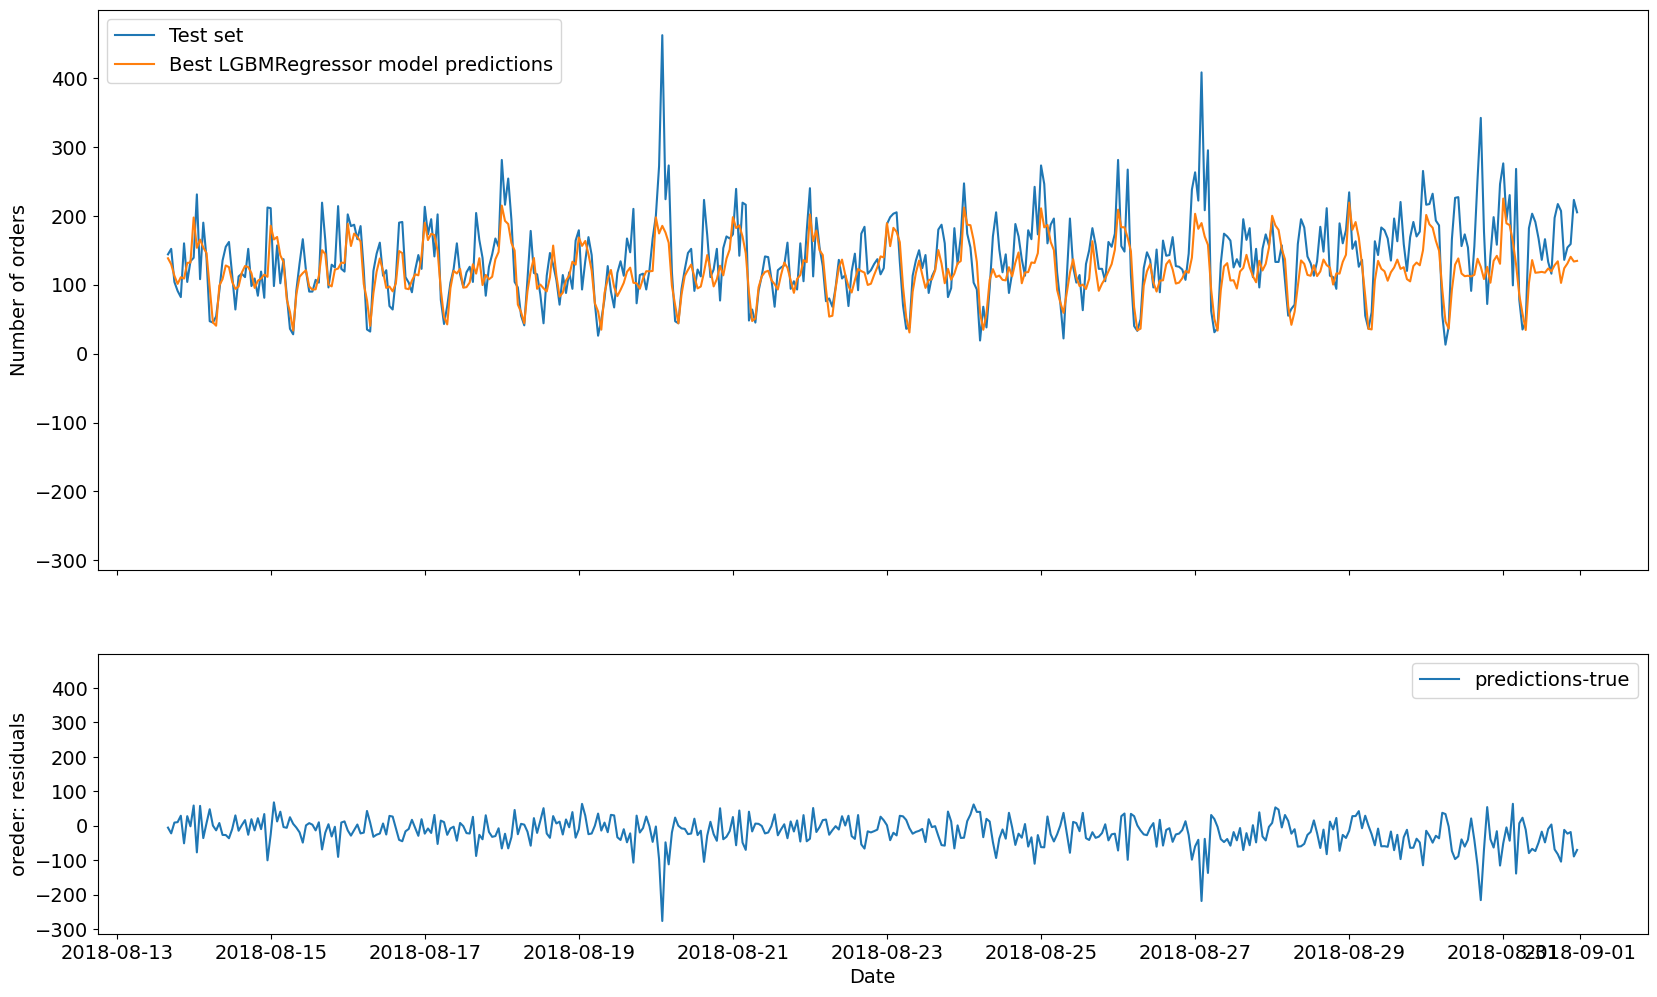

68% confidence interval = (-57.63092009208947, 23.82848629482727)


In [23]:
fig, ax = plt.subplots(2,1,figsize=(20,12)
                       ,sharex=True,sharey=True
                       ,gridspec_kw={'height_ratios': [2,1]})

sns.lineplot(data=y_test,ax=ax[0],label='Test set')
sns.lineplot(x=y_test.index,y=y_test_pred_best,ax=ax[0],
             label='Best LGBMRegressor model predictions'
            )
residuals = (y_test_pred_best-y_test)
sns.lineplot(data=residuals,ax=ax[1],label='predictions-true')

ax[0].set_xlabel(xlabel)
ax[0].set_ylabel(ylabel)
ax[1].set_xlabel(xlabel)
ax[1].set_ylabel('oreder: residuals')
plt.show()

print('68% confidence interval =',\
      st.norm.interval(confidence=0.68, loc=np.median(residuals),\
                       scale=st.sem(residuals,ddof=len(residuals)-1)))

We can see that the model captures seasonal variations, but not with full accuracy. Both visually and by calculating the 68% confidence interval, we observe that the model systematically underestimates the number of orders. This may be because we trained the model on the entire training dataset, which has a less pronounced overall trend compared to the test set. 

## Conclusion

We sucessfully trained a machine learning model to predict the required number of taxis per hour using historical data on airport taxi orders. The data from March to September 2018 represents a time series characterized by a non-stationary process. On average, the number of taxi orders increases over seven hourly intervals throughout the day. A general upward trend in the required number of taxis is observed from March to September, with monthly increases.

* The best-performing model was the gradient boosting model, which slightly outperformed the linear regression model. The RMSE metric of the best model on the test set is 45.

* The best model accurately predicts daily fluctuations in the number of taxi orders from August to September. However, it has a drawback: it tends to underestimate the number of required taxis, especially as September approaches.

Recommendation:
The number of taxis should be increased in the latter half of the day, with a larger adjustment as September nears, following the overall trend.